In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

In [2]:
df = pd.read_csv("../../data/wine_preprocessed.csv")
#df = pd.read_csv("../data/wine_red_white_preprocessed.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_3,quality_4,quality_5,quality_6,quality_7,quality_8,quality_9
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0,1,0,0,0,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0,1,0,0,0,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0,0,1,0,0,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,1,0,0,0,0


## Train/Test split

In [3]:
target_columns = ["quality_3", "quality_4", "quality_5", "quality_6", "quality_7", "quality_8", "quality_9"]
X = df.drop(target_columns, axis=1)
y = df[target_columns]

print(X.shape)
print(y.shape)

(6497, 11)
(6497, 7)


In [4]:
split_fraction = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_fraction, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5197, 11)
(1300, 11)
(5197, 7)
(1300, 7)


## Useful functions

In [5]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.callbacks import History
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [6]:
def get_sequential_model(
    nb_features, 
    nb_hidden_neurons, 
    nb_classes, 
    nb_hidden_layers=2, 
    hidden_activation="relu", 
    final_activation="softmax"
):
    model = Sequential()
    model.add(Input(shape=(nb_features,)))
    for i in range(0,nb_hidden_layers):
        model.add(Dense(nb_hidden_neurons, activation=hidden_activation, name=f"hidden_layer_{i}"))
    model.add(Dense(nb_classes, activation=final_activation, name="predictions"))
    
    return model

In [7]:
def plot_history(history):
    if isinstance(history, History):
        history = {"": history}
        
    fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(10,4))
    axs[0].set(xlabel="Epochs", ylabel="Loss", title="Training loss")
    axs[1].set(xlabel="Epochs", ylabel="Accuracy", title="Training accuracy")
    
    for k,h in history.items():
        loss = h.history['loss']
        accuracy = h.history['accuracy']
        axs[0].plot(range(len(loss)), loss, label=k)
        axs[1].plot(range(len(accuracy)), accuracy, label=k)    
    
    if len(history) > 1:
        axs[0].legend()
        axs[1].legend()
    plt.show()

In [8]:
def evaluate_model(model, X_test, y_test):
    results = model.evaluate(X_test, y_test)
    print(f"\nAccuracy on test set is {results[1]*100:.2f}%")

In [9]:
#Making sure the type is correct
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")

X_test = X_test.astype("float32")
y_test = y_test.astype("float32")


# TEST ZONE

In [10]:
# Setting some constants
nb_features = X_train.shape[1]
nb_classes = y_train.shape[1]
epochs = 50
batch_size = 5

verbose = 0

## Test 1 - Initial perceptron

In [11]:
# Setting some constants
nb_hidden_neurons = 10

In [12]:
model = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes)
model.layers

In [13]:
model.build(input_shape=(1, nb_features))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 10)                120       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 10)                110       
_________________________________________________________________
predictions (Dense)          (None, 7)                 77        
Total params: 307
Trainable params: 307
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras.losses import MSE, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001 
criterion = MSE
optimizer = Adam(learning_rate=learning_rate)  

In [16]:
model.compile(
    optimizer=optimizer, 
    loss=criterion,
    metrics= "accuracy"
)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

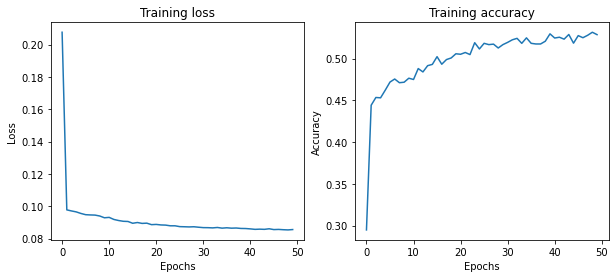

In [17]:
plot_history(history)

In [18]:
evaluate_model(model, X_test, y_test)

41/41 [==============================] - 1s 8ms/step - loss: 0.0876 - accuracy: 0.5177

Accuracy on test set is 51.77%


In [19]:
predictions = model.predict(X_test)
pred_classes = predictions.argmax(axis=-1) + 3
true_classes = y_test.to_numpy().argmax(axis=-1) + 3

pred_classes.shape

(1300,)

In [20]:
print(true_classes)
print(pred_classes)
df = pd.DataFrame({'true':true_classes, 'pred':pred_classes, 'v':1})
df = df.groupby(["true", "pred"]).agg(['count']).reset_index()
df

[8 5 7 ... 7 6 7]
[6 5 6 ... 6 5 5]


,true,pred,v
,,,count
0,3,5,4
1,3,6,2
2,4,5,34
3,4,6,9
4,5,5,307
5,5,6,95
6,6,5,231
7,6,6,362
8,6,7,4


(0.0, 10.0)

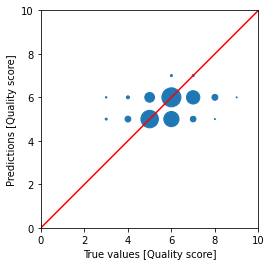

In [21]:
a = plt.axes(aspect='equal')
plt.scatter(df['true'], df['pred'], s=df['v'])
plt.xlabel("True values [Quality score]")
plt.ylabel("Predictions [Quality score]")
lims = [0,10]
plt.plot(lims,lims, c="r")
plt.xlim(lims)
plt.ylim(lims)

## Test 2 - Increase the size of hidden layers to 100

In [22]:
# Setting some constants
nb_hidden_neurons = 100

In [23]:
model_2 = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes)
model_2.build(input_shape=(1, nb_features))
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 100)               1200      
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 100)               10100     
_________________________________________________________________
predictions (Dense)          (None, 7)                 707       
Total params: 12,007
Trainable params: 12,007
Non-trainable params: 0
_________________________________________________________________


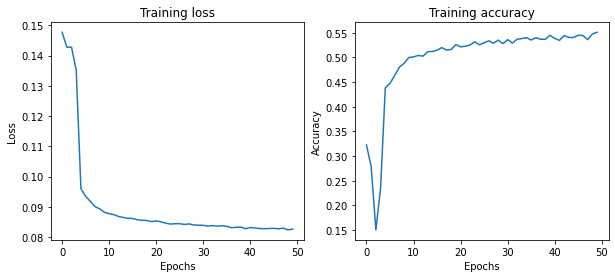

In [24]:
model_2.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")
history_2 = model_2.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_2)

In [25]:
evaluate_model(model_2, X_test, y_test)

41/41 [==============================] - 1s 11ms/step - loss: 0.0847 - accuracy: 0.5277 0s - loss: 0.0858 - accuracy: 

Accuracy on test set is 52.77%


## Test 3 - Increase the hidden layers to 25

In [26]:
# Setting some constants
nb_hidden_neurons = 25

In [27]:
model_3 = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes)
model_3.build(input_shape=(1, nb_features))
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 25)                300       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 25)                650       
_________________________________________________________________
predictions (Dense)          (None, 7)                 182       
Total params: 1,132
Trainable params: 1,132
Non-trainable params: 0
_________________________________________________________________


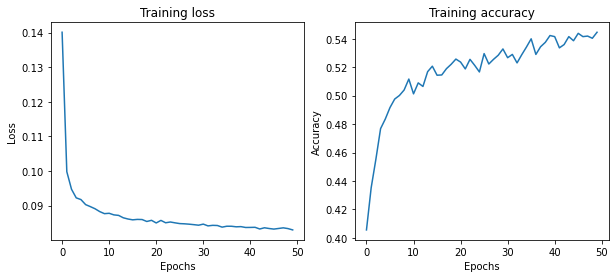

In [28]:
model_3.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")
history_3 = model_3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_3)

In [29]:
evaluate_model(model_3, X_test, y_test)

41/41 [==============================] - 0s 3ms/step - loss: 0.0894 - accuracy: 0.4962

Accuracy on test set is 49.62%


## Test 4 - Increase the amount of hidden layers

In [30]:
# Setting some constants
nb_hidden_neurons = 10
nb_hidden_layers = 3

In [31]:
model_4 = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)
model_4.build(input_shape=(1, nb_features))
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden_layer_0 (Dense)       (None, 10)                120       
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 10)                110       
_________________________________________________________________
hidden_layer_2 (Dense)       (None, 10)                110       
_________________________________________________________________
predictions (Dense)          (None, 7)                 77        
Total params: 417
Trainable params: 417
Non-trainable params: 0
_________________________________________________________________


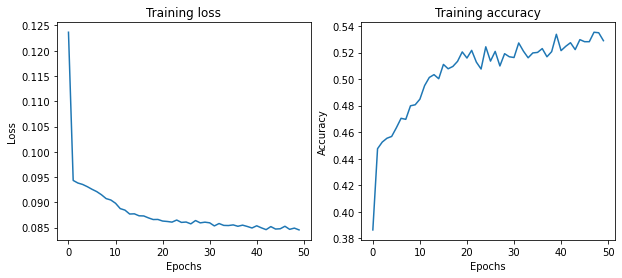

In [32]:
model_4.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")
history_4 = model_4.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_4)

In [33]:
evaluate_model(model_4, X_test, y_test)

41/41 [==============================] - 1s 4ms/step - loss: 0.0856 - accuracy: 0.5262

Accuracy on test set is 52.62%


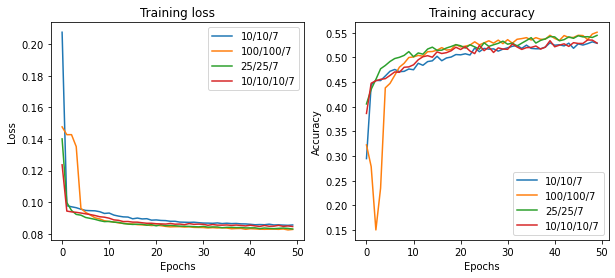

In [34]:
plot_history({"10/10/7":history, "100/100/7":history_2, "25/25/7": history_3, "10/10/10/7": history_4})

# Normalized data

In [35]:
normalizer = Normalizer()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)


In [36]:
# Setting some constants
nb_hidden_layers = 2

## Test 1 - Initial percetron

In [37]:
# Setting some constants
nb_hidden_neurons = 10

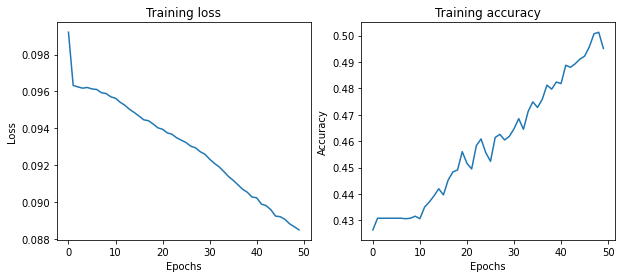

In [38]:
model_norm = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_norm.build(input_shape=(1, nb_features))
model_norm.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_norm = model_norm.fit(X_train_norm, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_norm)

In [39]:
evaluate_model(model_norm, X_test_norm, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.0887 - accuracy: 0.5008

Accuracy on test set is 50.08%


## Standardized data

In [40]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [41]:
# Setting some constants
nb_hidden_layers = 2

## Test 1 - Initial percetron

In [42]:
# Setting some constants
nb_hidden_neurons = 10

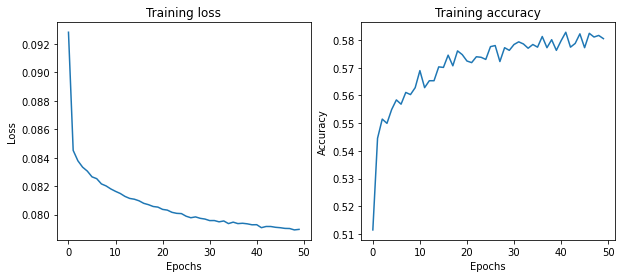

In [43]:
model_std = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_std.build(input_shape=(1, nb_features))
model_std.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_std = model_std.fit(X_train_std, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_std)

In [44]:
evaluate_model(model_std, X_test_std, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.0827 - accuracy: 0.5423

Accuracy on test set is 54.23%


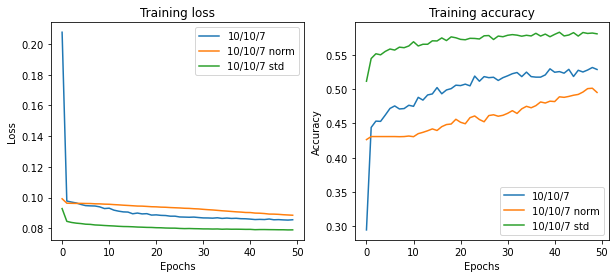

In [45]:
plot_history({"10/10/7":history, "10/10/7 norm":history_norm, "10/10/7 std": history_std})

# Resampling

In [46]:
# Import the resampling package
from sklearn.utils import resample

In [47]:
training_set = pd.concat([X_train, y_train], axis=1)

# Separating classes
quality_3 = training_set[training_set.quality_3 == 1]
quality_4 = training_set[training_set.quality_4 == 1]
quality_5 = training_set[training_set.quality_5 == 1]
quality_6 = training_set[training_set.quality_6 == 1]
quality_7 = training_set[training_set.quality_7 == 1]
quality_8 = training_set[training_set.quality_8 == 1]
quality_9 = training_set[training_set.quality_9 == 1]

## Undersampling the Majority

In [48]:
undersampling_limit = 250
classes = [quality_3, quality_4, quality_5, quality_6, quality_7, quality_8, quality_9]

In [49]:
for i in range(len(classes)):
    if len(classes[i]) > undersampling_limit:
        classes[i] = resample(classes[i], 
                              replace=True, 
                              n_samples=undersampling_limit,
                              random_state=42)
        
    
undersampled_train = pd.concat(classes)
undersampled_train.shape

(1108, 18)

In [50]:
X_train_down = undersampled_train.drop(target_columns, axis=1)
y_train_down = undersampled_train[target_columns]

# Make sure that type is correct
X_train_down = X_train_down.astype("float32")
y_train_down = y_train_down.astype("float32")

## Test 1 - Initial perceptron

In [51]:
# Setting some constants
nb_hidden_layers = 2
nb_hidden_neurons = 10

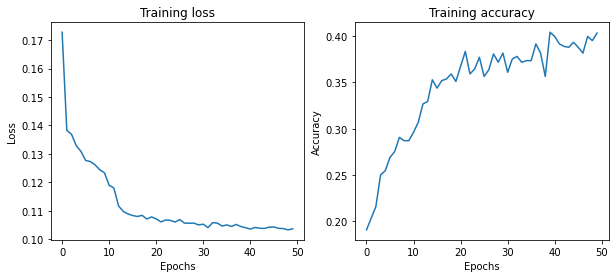

In [52]:
model_down = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_down.build(input_shape=(1, nb_features))
model_down.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_down = model_down.fit(X_train_down, y_train_down, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_down)

In [53]:
evaluate_model(model_down, X_test, y_test)

41/41 [==============================] - 0s 2ms/step - loss: 0.1024 - accuracy: 0.3831

Accuracy on test set is 38.31%


## Test 2 - Normalized data

In [54]:
X_train_down_norm = normalizer.transform(X_train_down)

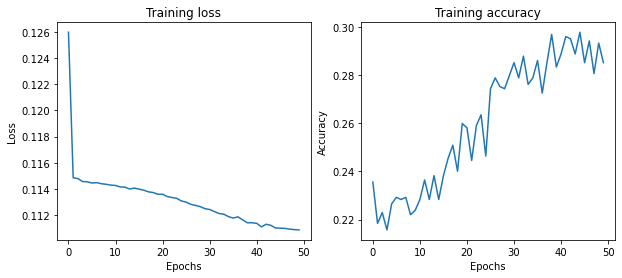

In [55]:
model_down_norm = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_down_norm.build(input_shape=(1, nb_features))
model_down_norm.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_down_norm = model_down_norm.fit(X_train_down_norm, y_train_down, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_down_norm)

In [56]:
evaluate_model(model_down_norm, X_test_norm, y_test)

41/41 [==============================] - 0s 1ms/step - loss: 0.1092 - accuracy: 0.2269

Accuracy on test set is 22.69%


## Test 2 - Standardized data

In [57]:
X_train_down_std = scaler.transform(X_train_down)

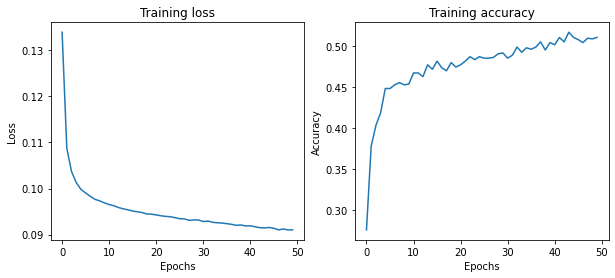

In [58]:
model_down_std = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_down_std.build(input_shape=(1, nb_features))
model_down_std.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_down_std = model_down_std.fit(X_train_down_std, y_train_down, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_down_std)

In [59]:
evaluate_model(model_down_std, X_test_std, y_test)

41/41 [==============================] - 0s 1ms/step - loss: 0.1026 - accuracy: 0.4085

Accuracy on test set is 40.85%


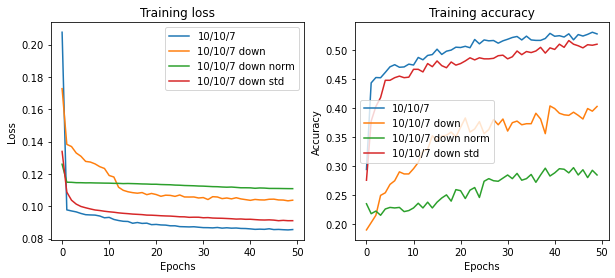

In [60]:
plot_history({"10/10/7":history, "10/10/7 down":history_down, "10/10/7 down norm":history_down_norm, "10/10/7 down std": history_down_std})

# Oversampling the minority

In [61]:
oversampling_limit = len(quality_6)
#classes = [quality_3, quality_4, quality_5, quality_6, quality_7, quality_8, quality_9]

In [62]:
for i in range(len(classes)):
    if len(classes[i]) < oversampling_limit:
        classes[i] = resample(classes[i], 
                              replace=True, 
                              n_samples=oversampling_limit,
                              random_state=42)
        
    
oversampled_train = pd.concat(classes)
oversampled_train.shape

TypeError: 'float' object cannot be interpreted as an integer

In [ ]:
X_train_up = oversampled_train.drop(target_columns, axis=1)
y_train_up = oversampled_train[target_columns]

# Make sure that type is correct
X_train_up = X_train_up.astype("float32")
y_train_up = y_train_up.astype("float32")

In [ ]:
# Setting some constants
nb_hidden_layers = 2
nb_hidden_neurons = 10
epochs = 50

## Test 1 - Initial perceptron

In [ ]:
model_up = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_up.build(input_shape=(1, nb_features))
model_up.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_up = model_down.fit(X_train_up, y_train_up, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_up)

In [ ]:
evaluate_model(model_up, X_test, y_test)

## Test 2 - Normalized data

In [ ]:
X_train_up_norm = normalizer.transform(X_train_up)

In [ ]:
model_up_norm = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_up_norm.build(input_shape=(1, nb_features))
model_up_norm.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_up_norm = model_up_norm.fit(X_train_up_norm, y_train_up, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_up_norm)

In [ ]:
evaluate_model(model_up_norm, X_test_norm, y_test)

## Test 3 - Standardized data

In [ ]:
X_train_up_std = scaler.transform(X_train_up)

In [ ]:
model_up_std = get_sequential_model(nb_features, nb_hidden_neurons, nb_classes, nb_hidden_layers)

model_up_std.build(input_shape=(1, nb_features))
model_up_std.compile(optimizer=optimizer, loss=criterion, metrics= "accuracy")

history_up_std = model_up_norm.fit(X_train_up_std, y_train_up, epochs=epochs, batch_size=batch_size, verbose=verbose)
plot_history(history_up_std)

In [ ]:
evaluate_model(model_up_std, X_test_std, y_test)

In [ ]:
plot_history({"10/10/7":history, "10/10/7 up":history_up, "10/10/7 up norm":history_up_norm, "10/10/7 up std": history_up_std})